In [ ]:
!pip install pandas numpy nltk seaborn matplotlib scikit-learn transformers torch datasets

In [2]:
nltk.download('punkt')  # For tokenization
nltk.download('stopwords')  # If you need stopwords

In [3]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import (AutoTokenizer, DataCollatorWithPadding,
                          AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, EarlyStoppingCallback)
from datasets import Dataset
import torch
import nltk

In [9]:
df = pd.read_csv('dataset/filtered.csv', encoding='ISO-8859-1')

# Display the first few rows of the dataset
df.head()

,text,target,Word Count
0,"python courses python courses, python exercise...",academic interests,125
1,the learning point open digital education. a r...,academic interests,147
2,"tech news, latest technology, mobiles, laptops...",academic interests,143
3,the best it certification materials in usa | k...,academic interests,364
4,"bioland scientific, for your research needs bi...",academic interests,176


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697527 entries, 0 to 697526
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        697527 non-null  object
 1   target      697527 non-null  object
 2   Word Count  697527 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 16.0+ MB


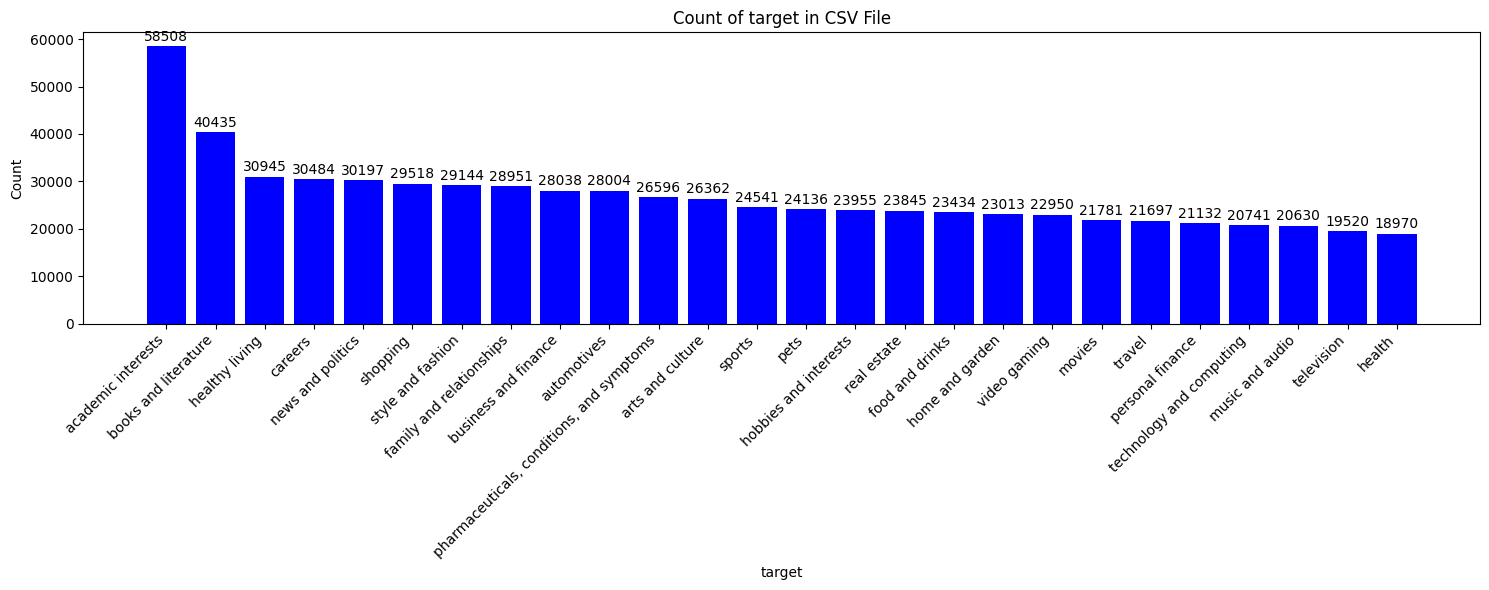

In [20]:
# Assuming df is already defined and contains the 'target' column
column_name = 'target'  # Change to your specific column name

# Count unique values in the DataFrame
count = df[column_name].value_counts().reset_index()
count.columns = [column_name, 'Count']

# Plotting the counts
plt.figure(figsize=(10, 6))

# Bar plot for counts
plt.bar(count[column_name], count['Count'], color='blue')

# Adding labels and title
plt.xlabel(column_name)
plt.ylabel('Count')
plt.title(f'Count of {column_name} in CSV File')

# Annotate counts on the plot
for i in range(len(count)):
    plt.annotate(f'{count["Count"].iloc[i]}', 
                 xy=(count[column_name].iloc[i], count['Count'].iloc[i] + 500),
                 ha='center', va='bottom', color='black')

# Add x-ticks
plt.xticks(ticks=range(len(count)), labels=count[column_name], rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Preprocessing function to remove unwanted characters
def remove_punctuations(text):
    text = re.sub(r'[\\-]', ' ', text)
    text = re.sub(r'[,.?;:\'(){}!|0-9]', '', text)
    return text

# Apply preprocessing to the text
df['text'] = df['text'].apply(remove_punctuations)

# Display the cleaned dataset
df.head()


In [ ]:
from nltk.corpus import stopwords

# english stopwords
stopw=stopwords.words('english')
stopw[:10]
def remove_stopwords(text):
    clean_text=[]
    for word in text.split(' '):
        if word not in stopw:
            clean_text.append(word)
    return ' '.join(clean_text)

# remove stopwords
df['text']=df['text'].apply(remove_stopwords)

df.head()

In [ ]:
# Split dataset into training and testing sets
train_df, test_df = train_test_split(df[['text', 'target']], train_size=0.8, shuffle=True)
test_df = test_df[:10000]  # Limit the test set to 10k for faster processing

# Display the shapes of the training and testing sets
print(train_df.shape, test_df.shape)

# Check device and set the model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


In [ ]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Preprocessing and dataset pipeline functions
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding='max_length', max_length=512)

def create_label_mapping(dataframe):
    unique_labels = dataframe['target'].unique()
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
    return label_mapping

def pipeline(dataframe, label_mapping):
    dataset = Dataset.from_pandas(dataframe, preserve_index=False)
    tokenized_ds = dataset.map(preprocess_function, batched=True)

    # Map the string labels to integers
    tokenized_ds = tokenized_ds.map(lambda x: {'labels': label_mapping[x['target']]})
    tokenized_ds = tokenized_ds.remove_columns('text')  # Remove text column if not needed
    return tokenized_ds

In [ ]:
label_mapping = create_label_mapping(train_df)
# Print the label mapping
print("Label Mapping:")
for label, idx in label_mapping.items():
    print(f"{idx}: {label}")

In [ ]:
tokenized_train = pipeline(train_df, label_mapping)
tokenized_test = pipeline(test_df, label_mapping)
# Create label mappings (label2id and id2label)
label2id = label_mapping  # label name to id
id2label = {v: k for k, v in label_mapping.items()}  # id to label name
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))
model.to(device)
# Add label mappings to the model's config
model.config.label2id = label2id
model.config.id2label = id2label

In [ ]:
# Set up training arguments with early stopping
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy='epoch',
    optim='adamw_torch',
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    num_train_epochs=3,  # Total number of epochs
    weight_decay=0.01,
    evaluation_strategy="epoch",  # Evaluate after each epoch
    load_best_model_at_end=True,  # Load the best model when finished training
    metric_for_best_model="eval_loss",  # Metric to compare to determine the best model
    greater_is_better=False,  # We want the eval loss to decrease
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=500,  # Log every 500 steps
    eval_steps=500,  # Evaluate every 500 steps
    save_total_limit=1,  # Only save the best model
)

# Define early stopping criteria
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  # Stop training if no improvement for 3 epochs
    early_stopping_threshold=0.01  # Minimum improvement threshold
)

In [ ]:
# Create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create the Trainer with early stopping callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[early_stopping_callback],  # Add the early stopping callback
)

# Train the model
trainer.train()

In [ ]:
# Prepare test dataset for predictions
tokenized_test = pipeline(test_df, label_mapping)
tokenized_test = tokenized_test.remove_columns('target')

In [ ]:
# Get predictions
preds = trainer.predict(tokenized_test)

# Create a reverse mapping for classification report
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Convert the test labels to numeric
test_df['numeric_labels'] = test_df['target'].map(label_mapping)

# Process predictions for classification report
preds_flat = [np.argmax(x) for x in preds[0]]

# Generate the classification report
print(classification_report(test_df['numeric_labels'], preds_flat))

In [ ]:
# Save the model
trainer.save_model('models2')

In [2]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('predictions.csv')

# Remove the column(s) you want to drop (e.g., 'column_name')
df = df.drop(columns=['text'])

# Save the modified DataFrame to a new CSV file
df.to_csv('new.csv', index=False)

print(f"Column removed and updated data saved to 'path_to_new_file.csv'.")


Column removed and updated data saved to 'path_to_new_file.csv'.
